In [77]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from scipy.optimize import fsolve, minimize
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [78]:
def BSM(S, K, r, sigma, tau):
    d1 = (np.log(S/K) + (r + np.power(sigma, 2) /2) * tau)/(sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    price = stats.norm.cdf(d1) * S - stats.norm.cdf(d2) * K * np.exp(-r * tau)
    return price

def ImpliedVol(S, K, r, price, tau):
    f = lambda sigma: price - BSM(S, K, r, sigma, tau)
    return fsolve(f, [0.1])[0]

def delta(S, r, data):
    d1 = (np.log(S/data['Strike']) + (r + np.power(data['imp_vol'], 2)/2)*data['Expiry'] / 365)/(data['imp_vol']*np.sqrt(data['Expiry'] / 365))
    delta = stats.norm.cdf(d1)
    return delta

def vega(S, r, data):
    d1 = (np.log(S/data['Strike']) + (r + np.power(data['imp_vol'], 2)/2)*data['Expiry'] / 365)/(data['Implied Vol']*np.sqrt(data['Expiry'] / 365))
    vega = S * np.sqrt(data['Expiry'] / 365) * stats.norm.pdf(d1) / 100
    return vega

In [79]:
data = pd.read_csv(r'/Users/tk/Documents/GitHub/Speciale/data/spx_options.csv', sep=';', decimal=',')
data.drop(columns=['Bid', 'Ask'], inplace=True)

S = 4523
r = 0

data['log_moneyness'] = np.log(data['Strike']/S)

length = data.shape[0]

In [80]:
imp_vol = np.zeros((length,1))

for i in range(length):
    imp_vol[i] = ImpliedVol(S, data.loc[i][1], r, data.loc[i][0], data.loc[i][2] / 365)

data['imp_vol'] = np.log(imp_vol)

data = data[data['imp_vol']<2]

/Users/tk/Documents/thematrix/lib/python3.10/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/var/folders/8r/_6h7xydd2wg1psfgy9ff5sfr0000gn/T/ipykernel_2591/1875494295.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


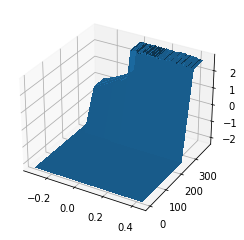

In [82]:
x1 = np.linspace(data['log_moneyness'].min(), data['log_moneyness'].max(), len(data['log_moneyness'].unique()))
y1 = np.linspace(data['Expiry'].min(), data['Expiry'].max(), len(data['Expiry'].unique()))

x2, y2 = np.meshgrid(x1, y1)

z2 = griddata((data['log_moneyness'], data['Expiry']), data['imp_vol'], (x2, y2), method='nearest')

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1,
                       linewidth=0, antialiased=False)

plt.show()